In [1]:
import torch
import torchvision
import torch.utils.data.dataloader as DataLoader
from torchvision.datasets import ImageFolder as IF

# Procesamiento
Todos estos pasos son para el procesamiento de las imágenes, utilizando dataloader que gestiona el preprocesamiento de las imagenes al igual que darle los batches de imágenes a la red neuronal.

In [43]:
import torchvision.transforms as transf

path = "/home/alex/Documents/Github/M_Vision_GeneracionEmociones/Datasets_juntos/ejecucion/"

transformaciones = transf.Compose([transf.Grayscale(num_output_channels=1), 
                                   transf.Resize((32,32)),
                                   transf.ToTensor(),
                                   transf.Normalize((0.5,), (0.5,))])

imagenes = IF(root=path, transform=transformaciones)

dataloader = DataLoader.DataLoader(imagenes, batch_size=1024, shuffle=True)

## Discriminador
Esta es la arquitectura del discriminador, el cual tiene la única tarea de clasificar imagenes como reales o generadas (Clasificador binario)

## Importante
Para asegurarse que las imagenes sean del tamaño requerido en cada convolución (dado el tamaño del brinco, el tamaño del kernel y el padding) usar la siguiente formula:
Tamaño = (Tamaño_original - tamaño_kernel + 2 * padding) / brinco + 1

In [44]:
import torch.nn.init as init

In [45]:
ndf = 64
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # First layer: input is (nc) x 32 x 32
        self.layer1 = torch.nn.Conv2d(1, ndf, 4, 2, 1, bias=False)
        self.leaky_relu1 = torch.nn.LeakyReLU(0.2, inplace=True)

        # Second layer: state size (ndf) x 16 x 16
        self.layer2 = torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(ndf * 2)
        self.leaky_relu2 = torch.nn.LeakyReLU(0.2, inplace=True)

        # Third layer: state size (ndf*2) x 8 x 8
        self.layer3 = torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(ndf * 4)
        self.leaky_relu3 = torch.nn.LeakyReLU(0.2, inplace=True)

        # Fourth layer: state size (ndf*4) x 4 x 4
        self.layer4 = torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
        self.sigmoid = torch.nn.Sigmoid()

        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)

    def forward(self, x):
        # Define the forward pass explicitly using the layers
        x = self.leaky_relu1(self.layer1(x))
        x = self.leaky_relu2(self.batchnorm2(self.layer2(x)))
        x = self.leaky_relu3(self.batchnorm3(self.layer3(x)))
        x = self.sigmoid(self.layer4(x))

        return x

## Generador
Esta es la arquitectura del generador, el cual tiene la tarea de recibir un vector con ruido e irlo rduciendo de profundidad e incrementando de tamaño hasta llegar al tamaño definido de 32x32x1

In [46]:
vector_ruido = 128
ngf = 64

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # First layer: input is Z, going into a convolution
        self.layer1 = torch.nn.ConvTranspose2d(vector_ruido, ngf * 4, 4, 1, 0, bias=False)
        
        self.batchnorm1 = torch.nn.BatchNorm2d(ngf * 4)
        self.relu1 = torch.nn.ReLU(True)

        # Second layer: state size (ngf*4) x 4 x 4 (to match the discriminator input size)
        self.layer2 = torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(ngf * 2)
        self.relu2 = torch.nn.ReLU(True)

        # Third layer: state size (ngf*2) x 8 x 8
        self.layer3 = torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(ngf)
        self.relu3 = torch.nn.ReLU(True)

        # Fourth layer: state size (ngf) x 16 x 16
        self.layer4 = torch.nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False) # Se reduce todo a un canal
        self.tanh = torch.nn.Tanh()

        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        

    def forward(self, x):
        # Define the forward pass explicitly using the layers
        x = self.relu1(self.batchnorm1(self.layer1(x)))
        x = self.relu2(self.batchnorm2(self.layer2(x)))
        x = self.relu3(self.batchnorm3(self.layer3(x)))
        x = self.tanh(self.layer4(x))

        return x

In [47]:
# Creamos una instancia de los dos modelos 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netD = Discriminator().to(device)
netG = Generator().to(device)



In [48]:
lr = 0.0001
# Initialize the ``BCELoss`` function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, vector_ruido, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

## Entrenamiento

In [49]:
def crear_batch(data):
    img_batch = data[0].to(device)
    tamano = img_batch.size(0)
    label = torch.full((tamano,), real_label, device=device)
    return img_batch, label, tamano

def crear_batch_falso(tamano, label):
    ruido = torch.randn(tamano, vector_ruido, 1, 1, device=device)
    batch_falso = netG(ruido)
    label.fill_(fake_label)
    return batch_falso, label


In [56]:
import numpy as np
img_list = []
G_losses = []
D_losses = []
num_epochs = 1000
iters = 0
import torchvision.utils as vutils
import time
start_time = time.time()
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        #Creamos batch de imagenes reales y calculamos el desempeño del discriminador
        img_batch, label, tamano = crear_batch(data)
        clasif = netD(img_batch).view(-1)
        #print("Clasificacion shape: ", clasif.shape, "Label shape: ", label.shape)
        disc_error = criterion(clasif, label)
        #print("Error D real: ", disc_error.item())
        disc_error.backward() # Se propaga el error para ajustar pesos
        disc_loss = clasif.mean().item()

        #Creamos batch de imagenes falsas y calculamos el desempeño del discriminador
        batch_falso, label = crear_batch_falso(tamano, label)
        clasif_f = netD(batch_falso.detach()).view(-1) #La pasamos al discriminador
        disc_error_f = criterion(clasif_f, label)
        disc_error_f.backward()
        D_G_z1 = clasif_f.mean().item()
        errD = disc_error + disc_error_f
        optimizerD.step()


        netG.zero_grad()
        label.fill_(real_label)
        output = netD(batch_falso).view(-1)
        errG = criterion(output, label) # Evaluamos sobre lo que el discriminador clasifico de un batch falso
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step() #Ajustamos pesos usando ADAM

        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), disc_loss, D_G_z1, D_G_z2))
            
        G_losses.append(errG.item())
        D_losses.append(errD.item())


end_time = time.time()
print("Training time: ", end_time - start_time)

Starting Training Loop...
[0/1000][0/6]	Loss_D: 0.4954	Loss_G: 2.0299	D(x): 0.8048	D(G(z)): 0.2207 / 0.1628
[1/1000][0/6]	Loss_D: 0.5331	Loss_G: 2.3822	D(x): 0.8826	D(G(z)): 0.3136 / 0.1160
[2/1000][0/6]	Loss_D: 0.4937	Loss_G: 1.8383	D(x): 0.7877	D(G(z)): 0.2036 / 0.1986
[3/1000][0/6]	Loss_D: 0.6001	Loss_G: 2.9181	D(x): 0.8909	D(G(z)): 0.3576 / 0.0717
[4/1000][0/6]	Loss_D: 0.5332	Loss_G: 2.3044	D(x): 0.8746	D(G(z)): 0.3064 / 0.1256
[5/1000][0/6]	Loss_D: 0.5089	Loss_G: 2.0763	D(x): 0.8085	D(G(z)): 0.2335 / 0.1545
[6/1000][0/6]	Loss_D: 0.4713	Loss_G: 1.8249	D(x): 0.7816	D(G(z)): 0.1807 / 0.1943
[7/1000][0/6]	Loss_D: 0.5160	Loss_G: 1.5247	D(x): 0.7246	D(G(z)): 0.1499 / 0.2598
[8/1000][0/6]	Loss_D: 0.5299	Loss_G: 1.5723	D(x): 0.7018	D(G(z)): 0.1302 / 0.2463
[9/1000][0/6]	Loss_D: 0.5156	Loss_G: 1.4750	D(x): 0.7227	D(G(z)): 0.1491 / 0.2704
[10/1000][0/6]	Loss_D: 0.5241	Loss_G: 1.4849	D(x): 0.7087	D(G(z)): 0.1397 / 0.2649
[11/1000][0/6]	Loss_D: 0.5247	Loss_G: 1.5304	D(x): 0.7156	D(G(z)): 0.14

## Crear imagenes sobre modelos entrenados y salvar los modelos


In [54]:
import matplotlib.pyplot as plt
def save_models(netG, netD, sentimiento):
    torch.save(netG.state_dict(), 'modelos/G_{}.pth'.format(sentimiento))
    torch.save(netD.state_dict(), 'modelos/D_{}.pth'.format(sentimiento))


def crear_imagenes(sentimiento, iter):
    #Crear 9 imagenes desplegarlas en una matriz 3x3 y salvarlas
    todas_imagenes = []
    for i in range(9):
        fixed_noise = torch.randn(1, vector_ruido, 1, 1, device=device)
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        todas_imagenes.append(fake)
    # deplegar las imagenes en una matriz 3x3 con matplolib
    fig, axs = plt.subplots(3, 3)
    fig.suptitle('Imagenes generadas ({})'.format(sentimiento))
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(todas_imagenes[i*3+j][0][0], cmap='gray')
            axs[i, j].axis('off')
    plt.show()
    # guardar la plot
    fig.savefig('imagenes/imagen_generada_{}_{}.png'.format(sentimiento, iter))


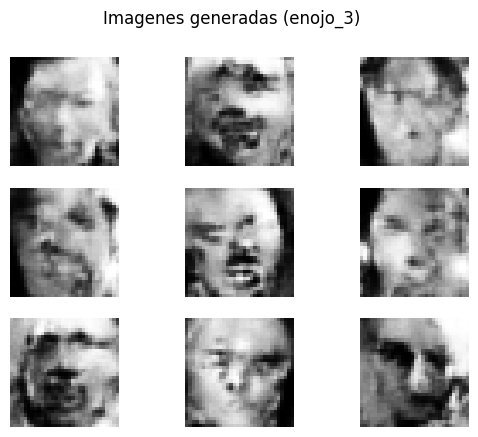

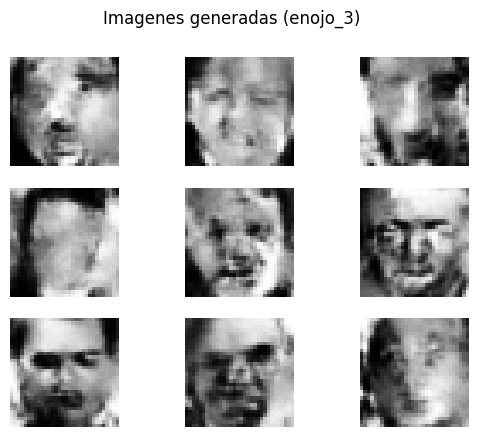

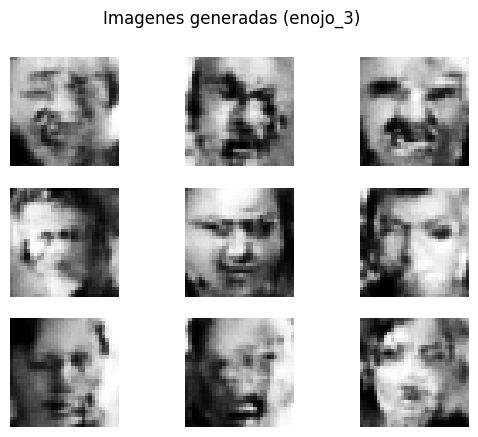

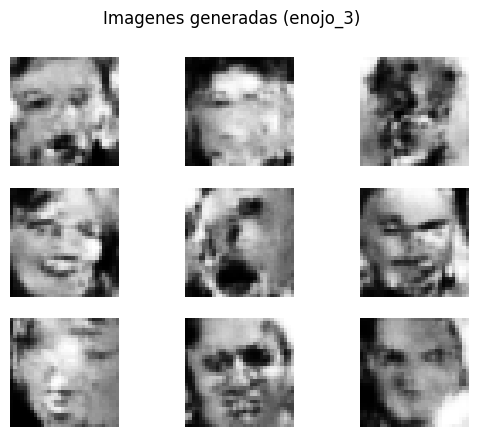

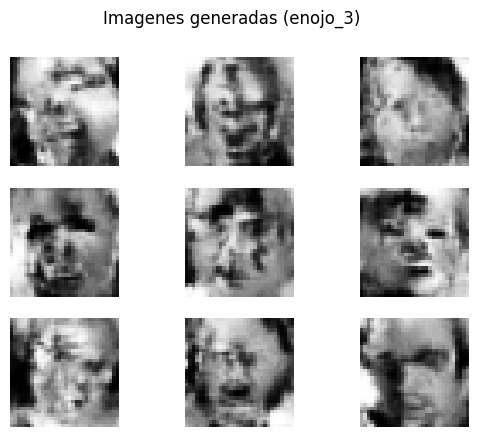

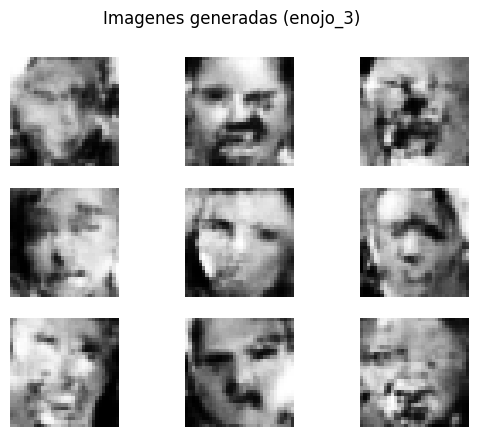

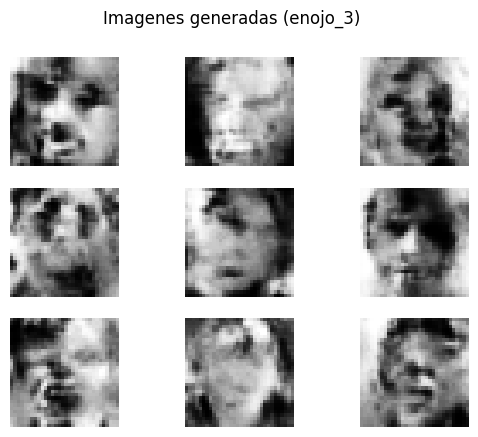

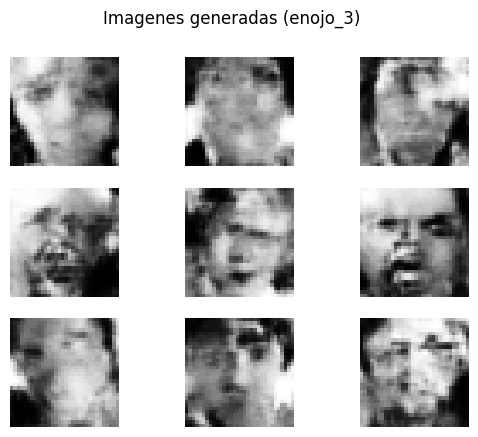

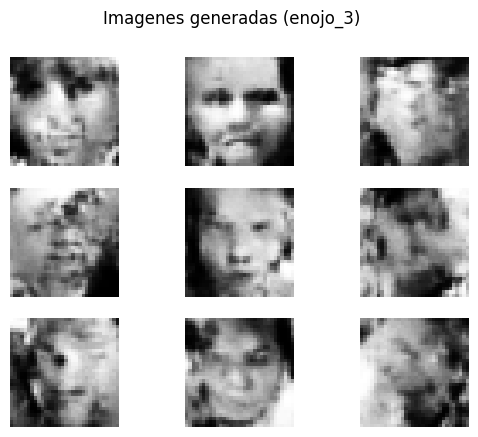

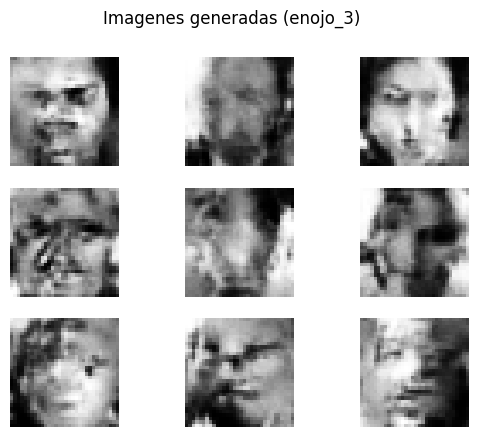

In [55]:
emocion = "enojo_3"
save_models(netG, netD, emocion)
for i in range(10):
    crear_imagenes(emocion,i)